# Hand-writting devset for framework validation
This script gets pictures from the ../data/raw_images/ folder.

Digits are extracted from those images then saved at ../data/recognized_digits/.

Digits are then able to get used as devset for frame framework model validation.

## Imports

In [1]:
import cv2
import os
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

## loading images from the ../data/raw_images/ folder

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

images = load_images_from_folder('../data/raw_images/')

In [3]:
def extract_digits_old(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digits = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        digit = gray[y:y+h, x:x+w]
        digits.append((digit, x, y, w, h))
    return digits


def extract_digits(img, margin=5):
    """
    Extract digits from an image with additional margin.

    Parameters:
    img (numpy.ndarray): The input image from which to extract digits.
    margin (int): Number of extra pixels to include around the digit as margin.

    Returns:
    list of tuple: Each tuple contains the digit image and its bounding box dimensions (x, y, w, h).
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digits = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Calculate new bounds considering the margin, and ensure they are within image boundaries
        x_new = max(x - margin, 0)
        y_new = max(y - margin, 0)
        w_new = w + 2 * margin
        h_new = h + 2 * margin
        # Adjust width and height to not exceed image dimensions
        if x_new + w_new > img.shape[1]:
            w_new = img.shape[1] - x_new
        if y_new + h_new > img.shape[0]:
            h_new = img.shape[0] - y_new
        # Extract the digit with the new bounds
        digit = gray[y_new:y_new + h_new, x_new:x_new + w_new]
        digits.append((digit, x_new, y_new, w_new, h_new))
    return digits



In [30]:
digits = []

for image in images:
    image_digits = extract_digits(image, margin=25)
    for digit in image_digits:
        digits.append(digit)
        
print("Detected", len(digits), "digits (Some of them are not digits but anomalies).")

Detected 196 digits (Some of them are not digits but anomalies).


## Dimensions distribution checking

Let's eliminate anomalies by width and height.

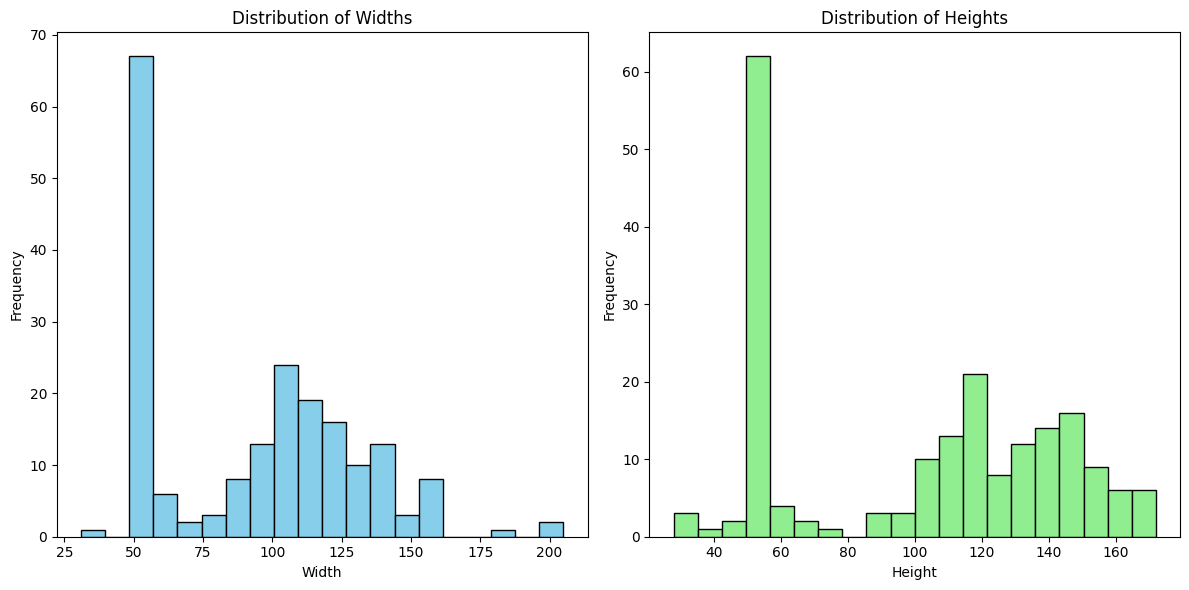

In [5]:
def display_dimensions_distribution(digits):
    """
    Display histograms of the widths and heights of digit bounding boxes.

    Parameters:
    digits (list of tuple): List of tuples, each containing the digit image and its bounding box dimensions (x, y, w, h).
    """
    widths = [w for _, x, y, w, h in digits]
    heights = [h for _, x, y, w, h in digits]

    # Create a figure with 2 subplots
    plt.figure(figsize=(12, 6))

    # Plot for widths
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Widths')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    # Plot for heights
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
    plt.title('Distribution of Heights')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    # Show the plot
    plt.tight_layout()
    plt.show()

display_dimensions_distribution(digits)

In [11]:
def filter_small_digits(digits, min_width, min_height):
    """
    Filter out digits that have both width and height smaller than specified thresholds.

    Parameters:
    digits (list of tuple): List of tuples, each containing the digit image and its bounding box dimensions (x, y, w, h).
    min_width (int): Minimum width threshold.
    min_height (int): Minimum height threshold.

    Returns:
    list of tuple: Filtered list of digits with acceptable sizes.
    """
    filtered_digits = []
    for digit, x, y, w, h in digits:
        if w >= min_width and h >= min_height:
            filtered_digits.append((digit, x, y, w, h))
    return filtered_digits

min_width = 65  # le seuil minimum de largeur
min_height = 80  # le seuil minimum de hauteur

# Filtrer les digits
filtered_digits = filter_small_digits(digits, min_width, min_height)
print(len(filtered_digits), "Digits after filtering.")

120


## Remaining digits displaying

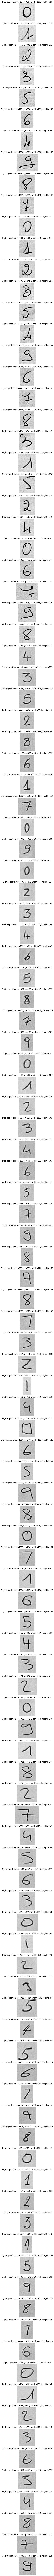

In [12]:
import matplotlib.pyplot as plt

def show_extracted_digits(digits):
    """
    Display the extracted digits in a Jupyter Notebook.

    Parameters:
    digits (list of tuple): List of tuples, each containing the digit image and its bounding box dimensions (x, y, w, h).
    """
    # Set up the figure size and the number of subplots
    plt.figure(figsize=(10, len(digits)*2))
    for i, (digit, x, y, w, h) in enumerate(digits, start=1):
        plt.subplot(len(digits), 1, i)
        plt.imshow(digit, cmap='gray')
        plt.title(f'Digit at position: x={x}, y={y}, width={w}, height={h}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_extracted_digits(filtered_digits)

## Digit formating,recognition with MNIST then saving

In [13]:
def load_pretrained_mnist_model():
    # Charger les données MNIST
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Prétraiter les données
    train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)).astype('float32') / 255
    test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)).astype('float32') / 255
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)

    # Charger un modèle MNIST pré-entraîné (utilisation d'un modèle simplifié ici pour l'exemple)
    # En pratique, vous utiliseriez `load_model('path_to_model.h5')` pour charger un modèle réel
    from tensorflow.keras import layers, models
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    # Compiler le modèle
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'mean_squared_error'])

    # Entraîner le modèle (normalement, vous chargeriez un modèle déjà entraîné)
    model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))

    return model

model = load_pretrained_mnist_model()  # Charger le modèle MNIST

Epoch 1/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1558 - acc: 0.9508 - mean_squared_error: 0.0071 - val_loss: 0.0506 - val_acc: 0.9841 - val_mean_squared_error: 0.0025
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0474 - acc: 0.9856 - mean_squared_error: 0.0023 - val_loss: 0.0372 - val_acc: 0.9872 - val_mean_squared_error: 0.0019
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0335 - acc: 0.9899 - mean_squared_error: 0.0016 - val_loss: 0.0292 - val_acc: 0.9906 - val_mean_squared_error: 0.0015
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0256 - acc: 0.9919 - mean_squared_error: 0.0012 - val_loss: 0.0391 - val_acc: 0.9880 - val_mean_squared_error: 0.0018
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0212 - acc: 0.9933 - mean_squared_error: 0.0010 - val_loss: 0.0282 - val_acc: 0.9915 - val_mean_squared_error: 0.0013


In [26]:
def process_and_save_digits(digits, model, save_dir, pixel_threshold=90):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    digit_count = {}
    
    for i, (digit_img, x, y, w, h) in enumerate(digits):
        # Resize the image
        resized_img = cv2.resize(digit_img, (28, 28), interpolation=cv2.INTER_AREA)
        # Invert colors (convert from black on white to white on black)
        resized_img = 255 - resized_img

        # convert grey to black
        resized_img[resized_img < pixel_threshold] = 0

        # convert remaining grey to white
        resized_img[resized_img > pixel_threshold] = 250

        resized_img = resized_img.reshape(1, 28, 28, 1)
        resized_img = resized_img / 255.0  # Normalize the pixels

        # Model prediction
        prediction = model.predict(resized_img)
        digit_class = np.argmax(prediction)
        
        # Manage file names to avoid duplicates
        if digit_class in digit_count:
            digit_count[digit_class] += 1
        else:
            digit_count[digit_class] = 1
        
        filename = f"{digit_class}_{digit_count[digit_class]}.png"
        file_path = os.path.join(save_dir, filename)
        # Save the inverted and normalized image
        cv2.imwrite(file_path, resized_img[0] * 255)  # Convert back to original pixel values before saving
        
        print(f"Saved {filename} to {save_dir}")

<div class="alert alert-block alert-warning">
<b>Example:</b> This model is not reliable to asign proper digit to images. If you use it for devset validation of the main framework (main.ipynb), check the digit assignment and correct it if necessary at "../data/recognized_digits/". 
</div>

In [27]:
process_and_save_digits(filtered_digits, model, "../data/recognized_digits/", pixel_threshold=110)

1/1 [==============================] - 0s 13ms/step
Saved 0_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 8ms/step
Saved 1_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 6ms/step
Saved 2_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 7ms/step
Saved 3_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 6ms/step
Saved 5_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 6ms/step
Saved 6_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 6ms/step
Saved 1_2.png to ../data/recognized_digits/
1/1 [==============================] - 0s 8ms/step
Saved 3_2.png to ../data/recognized_digits/
1/1 [==============================] - 0s 7ms/step
Saved 8_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 7ms/step
Saved 7_1.png to ../data/recognized_digits/
1/1 [==============================] - 0s 7ms/ste